# Dataset Selection

- Datasets: 191

- Samples: 29.198

### OpenRefine:
A powerful free, open source tool for working with messy data: cleaning it, transforming it from one format into another and extending it with web services and external data.

- Retrieve platform *technology* from [Gene Expression Omnibus](https://0-www-ncbi-nlm-nih-gov.brum.beds.ac.uk/geo/browse/?view=platforms):

  - high-throughput sequencing (64 datasets: 1473 samples)

  - spotted oligonucleotide (35 datasets: 24.119 samples)

  - in situ oligonucleotide (61 datasets: 2987 samples)

  - RT-PCR (28 datasets: 544 samples)

  - other (3 datasets: 75 samples)

- Delete datasets:

  - *technology* = other | [RT-PCR](https://biosistemika.com/blog/qpcr-microarrays-rna-sequencing-choose-one)

  - *dataset* = EMIR00000180 (64 samples) ([samples in common with EMIR00000177 but inconsistent values](./report.numbers))

  - *dataset* = EMIR00000091 | EMIR00000092 | EMIR00000097 | EMIR00000101 (subsets of EMIR00000102)

  - *dataset* = EMIR00000010 | EMIR00000011 | EMIR00000023 | EMIR00000026 | EMIR00000028 | EMIR00000038 | EMIR00000081 | EMIR00000095 | EMIR00000096 | EMIR00000123 | EMIR00000133 | EMIR00000137 | EMIR00000158 (441 samples) (Non-disease: e.g. Human mesenchymal stem cell, Hair follicle regeneration, Wound healing and myoblast formation)

# Metadata Preprocessing

- Features: 267

### OpenRefine

- Add dataset-level features.

- Split and transpose key:value features.

- Delete samples:

   - *organism* ≠ Homo sapiens (22 samples)

   - *channel_count* ≠ 1 (189 samples)

   - *molecule* ≠ total RNA (2 samples)

   - Disease status not clear (EMIR00000090: 13, EMIR00000008: 4, EMIR00000067: 3, EMIR00000102: 30, EMIR00000168: 9)

In [14]:
import pandas as pd


def keep_first_occurrence(row):
    """
    Delete repeated occurrences of the same value in a row
    """
    new_row = []
    for value in row:
        new_row.append(value if value not in new_row else None)
    return pd.Series(new_row, index=row.index)


metadata = pd.read_csv('data/PD.csv', dtype=str).apply(keep_first_occurrence, axis=1)

# Remove columns containing a unique value for all the rows
metadata.drop(metadata.columns[metadata.apply(pd.Series.nunique) == 1], axis=1, inplace=True)

# Remove empty columns
metadata.dropna(axis=1, how='all', inplace=True)

metadata.to_csv('data/PD.csv', index=False)

### OpenRefine

- Merge equivalent features associated to different datasets.

- Rename features consistently.

- Delete irrelevant or redundant features (e.g. *state* has an almost 1:1 relationship with *city*).

- Delete features where missing values ⪆ 98%.

- Refine dataset-level features (based on majority class) using sample-level data: *disease*, *disease_type*, *body_site*.
        
- Detect healthy samples in each dataset exploiting sample description.

- Extract *metastasis* and *stage* from sample description.

- Standardize *age*, *sex*, *city*, *disease*, *disease_type* values.

# miRNA Preprocessing 

In [125]:
import pandas as pd


name_conversions = {}
for _, row in pd.read_csv('data/raw/converter.csv', index_col=0).iterrows():
    for i in range(len(row) - 1):
        if row[i] != row[-1]:
            name_conversions[row[i]] = row[-1]
            

def transform_miRNA_name(name):
    """
    Delete whitespaces, standardize separators and remove version suffix from miRNA names. Update miRNA names to the latest version of miRBase.
    """
    name = name.replace(' ', '')
    name = name.replace(',hsa', '|hsa')
    name = name.replace('+hsa', '|hsa')
    name = name.replace('/hsa', '|hsa')
    name = name.replace('_hsa', '|hsa')
    name = name.split('_v1')[0]
    name = name.split('_v2')[0]
    name = name_conversions.get(name, name)
    return name


samples_per_dataset = pd.read_csv('data/PD.csv').groupby('dataset')['sample_id'].agg(list).to_dict()
df_list = []

for dataset in samples_per_dataset.keys():

    df = pd.read_csv(f'data/raw/exp/{dataset}_exp.csv', converters={0: transform_miRNA_name})

    # Delete rows indexed by the same miRNA name (dataset anomaly)
    df = df.drop_duplicates(df.columns[0])

    # Delete rows indexed by miRNA names containing 'plus', 'novel' (unknown miRNA), 'hsa-miR-647+a703' (dataset anomaly), '_var2' (dataset contains identical suffix-free miRNA)
    df = df[df[df.columns[0]].str.contains('plus|novel|hsa-miR-647\+a703|_var2') == False]

    # Transpose data
    df = df.set_index(df.columns[0]).T

    # Remove samples not included in metadata
    df = df.loc[samples_per_dataset[dataset]]
    
    df_list.append(df)

# Concatenate data into a single dataframe
values = pd.concat(df_list)

pd.DataFrame(values.count(axis=0), columns=['samples']).to_csv('data/miRNA.csv')
values.to_csv('data/EXP.csv')

- [Converter](http://mirandola.iit.cnr.it/converter.php)

- [Plus](https://www.tecan.com/hubfs/Tecan_Journal/200702/TecanJournal2007-02_page_16.pdf)

- [Novel](https://academic.oup.com/bfg/article/15/1/65/1742523)

# Visualization

Total samples: 27649


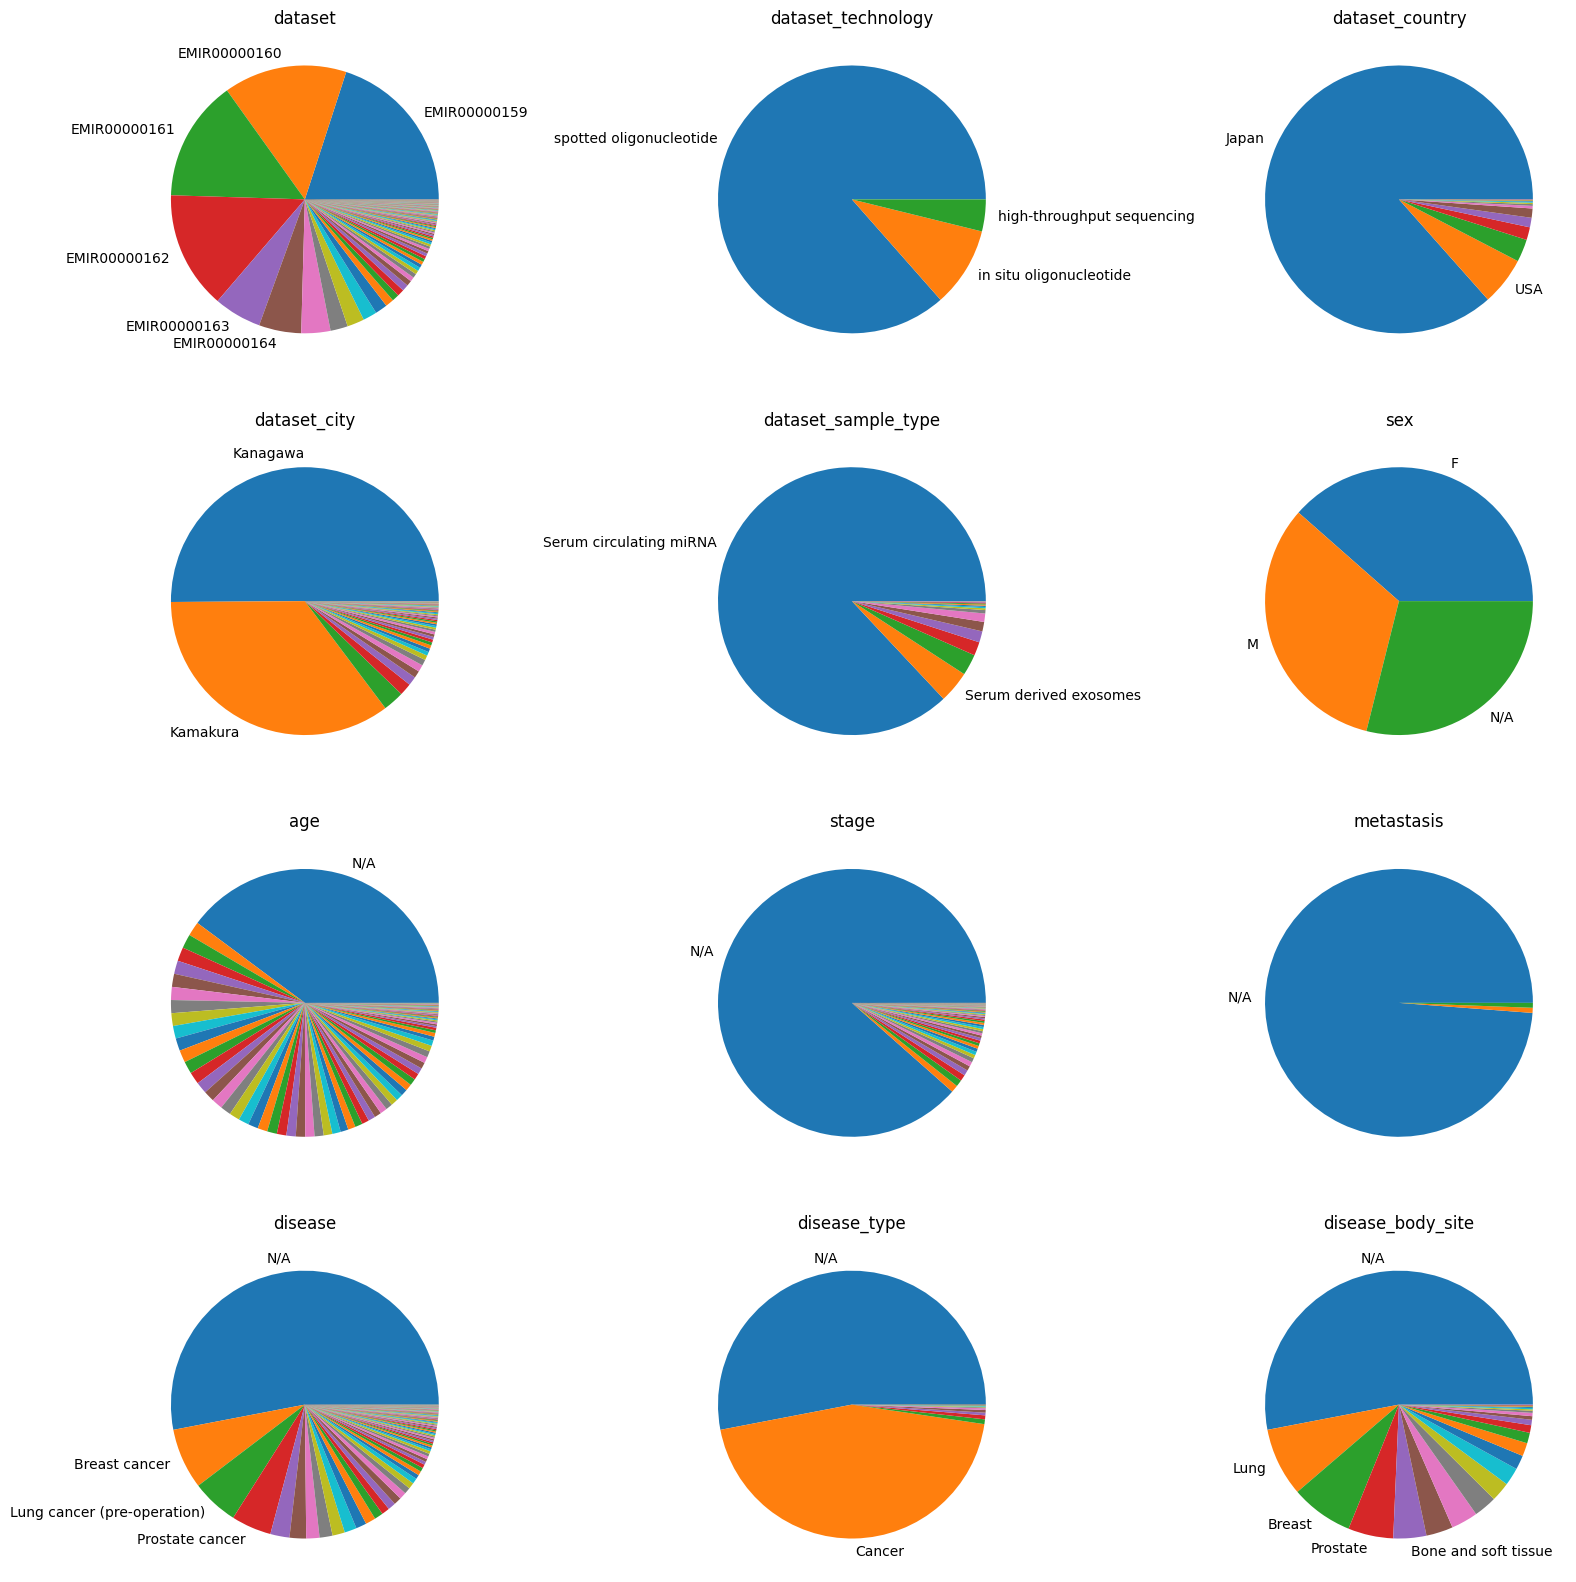

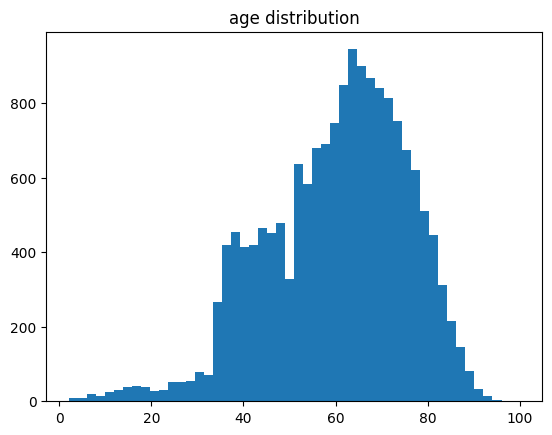

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data/PD.csv', index_col='sample_id')
print(f'\033[1mTotal samples: {len(df)}\033[0m')

fig, axs = plt.subplots(4, 3, figsize=(20, 20))
for i, column in enumerate(df.columns):

    counts = df[column].value_counts(dropna=False)
    labels = [label if count > 1000 else '' for count, label in zip(counts, counts.index)]
    labels = ['N/A' if pd.isnull(label) else label for label in labels]
    axs[i//3, i%3].set_title(f'{column}')
    axs[i//3, i%3].pie(counts, labels=labels)

plt.show()
plt.hist(df['age'], bins=50)
plt.title('age distribution')
plt.show()

# Issues


- Previous experiment: *disease* attribute extracted from dataset table but each dataset contains multiple diseases and healthy samples.

- Dataset integration is not recommended. If values in multiple datasets are not comparable, generated results are biased:

  - Different datasets use different value range: model will map the dataset range to its disease.

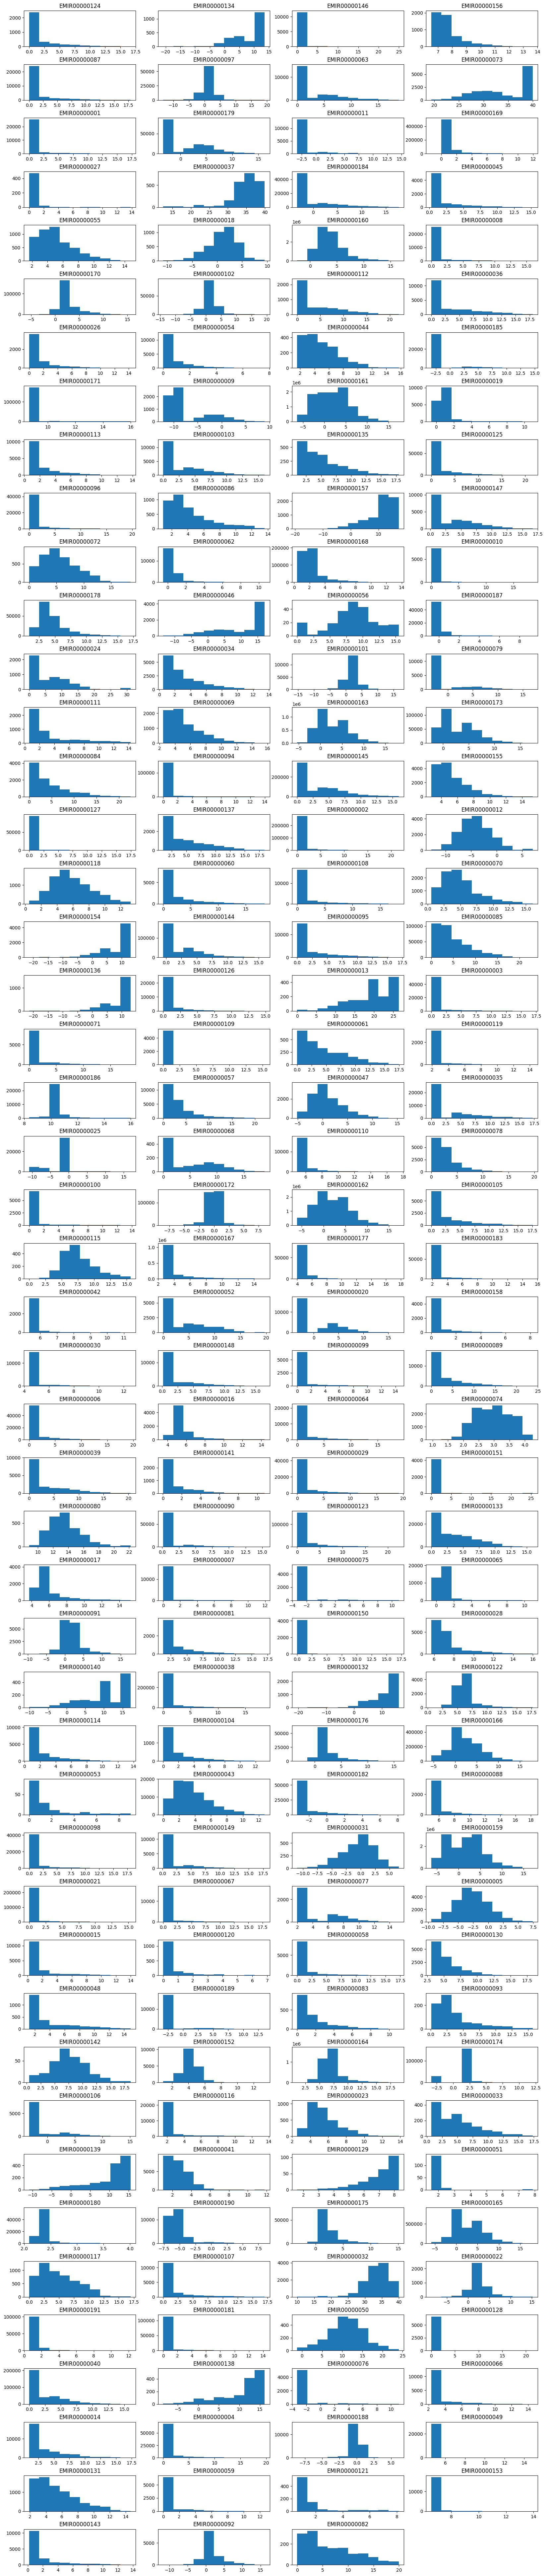

In [108]:
import glob
import pandas as pd
import matplotlib.pyplot as plt


fig, axs = plt.subplots(48, 4, figsize=(20, 100), gridspec_kw={'hspace': 0.5})
for i, filename in enumerate(glob.glob('data/raw/exp/*.csv')):
    values = pd.read_csv(filename, index_col=0).values.flatten()
    axs[i//4, i%4].hist(values)
    axs[i//4, i%4].set_title(filename.split('/')[-1][:-8])
    
axs[-1, -1].set_visible(False)

plt.show()

- Select datasets and diseases:

  - Frequency threshold

  - Absence of healthy samples (some datasets consider specific aspects of a particular disease)

- Select miRNA:

  - Frequency threshold
    
  - Presence of separators: ...|...|...

- Interpret miRNA values equal to 0.

- Meaning of *metastasis* and *stage* is dataset-specific.

- Aggregate *disease* and *stage* values.

- Define graph structure.

# Graph Construction

### PyG:
A library built upon PyTorch to easily write and train Graph Neural Networks for a wide range of applications related to structured data.

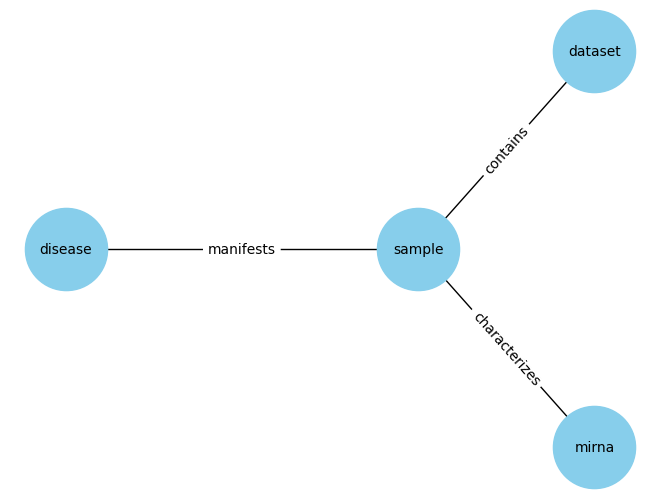


Node number
sample         : 27649
dataset        : 137
disease        : 115
mirna          : 8165

Edge number
contains       : 27649
manifests      : 12990
characterizes  : 64926240

Node features
sample         : 3
dataset        : 102
disease        : 38
mirna          : 0

Edge features
contains       : 0
manifests      : 107
characterizes  : 1


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import HeteroData
from torch_geometric import transforms as T 


graph = HeteroData()
metadata = pd.read_csv('data/PD.csv', index_col=0).sort_index().reset_index(drop=True)
mirna = pd.read_csv('data/EXP.csv', index_col=0).sort_index().reset_index(drop=True)

# Set features for 'sample' nodes
sex = torch.tensor(pd.get_dummies(metadata.sex).values, dtype=torch.float)
age = torch.tensor(metadata.age.values, dtype=torch.float).unsqueeze(-1)
graph['sample'].x = torch.cat((sex, age), dim=-1)

# Set features for 'dataset' nodes
datasets = metadata.loc[:, metadata.columns.str.startswith('dataset')].groupby('dataset').first()
xs = [torch.tensor(pd.get_dummies(datasets[feature]).values, dtype=torch.float) for feature in datasets.columns]
graph['dataset'].x = torch.cat(xs, dim=-1).to_sparse()

# Set features for 'disease' nodes
diseases = metadata.loc[:, metadata.columns.str.startswith('disease')].groupby('disease').first()
xs = [torch.tensor(pd.get_dummies(diseases[feature]).values, dtype=torch.float) for feature in diseases.columns]
graph['disease'].x = torch.cat(xs, dim=-1).to_sparse()

# Set number of 'mirna' nodes
graph['mirna'].num_nodes = mirna.shape[1]

# Set 'contains' edges between 'dataset' and 'sample' nodes
graph['dataset', 'contains', 'sample'].edge_index = torch.tensor(np.array([metadata.dataset.factorize()[0], metadata.index.to_numpy()]))

# Set 'manifests' edges between 'sample' and 'disease' nodes
unhealthy_samples = metadata[metadata.disease.notnull()]
graph['sample', 'manifests', 'disease'].edge_index = torch.tensor(np.array([unhealthy_samples.index.to_numpy(), unhealthy_samples.disease.factorize()[0]]))

# Set 'characterizes' edges between 'mirna' and 'sample' nodes
rows, cols = np.where(~np.isnan(mirna))
graph['mirna', 'characterizes', 'sample'].edge_index = torch.tensor(np.array([cols, rows]))

# Set features for 'manifests' edges
stage = torch.tensor(pd.get_dummies(unhealthy_samples.stage).values, dtype=torch.float)
metastasis = torch.tensor(pd.get_dummies(unhealthy_samples.metastasis).values, dtype=torch.float)
graph['sample', 'manifests', 'disease'].edge_attr = torch.cat((stage, metastasis), dim=-1).to_sparse()

# Set features for 'characterizes' edges
graph['mirna', 'characterizes', 'sample'].edge_attr = torch.tensor(mirna.values[rows, cols])

# Check that edge_index holds indices in the range [0, num_nodes-1]
graph.validate(raise_on_error=True)

# Visualize graph schema
schema = nx.Graph()
schema.add_nodes_from(graph.node_types)
edges = {(e[0], e[2]): e[1] for e in graph.edge_types}
schema.add_edges_from(edges.keys())
pos = nx.kamada_kawai_layout(schema)
nx.draw(schema, pos, with_labels=True, node_color='skyblue', node_size=3500, font_size=10)
nx.draw_networkx_edge_labels(schema, pos, edge_labels=edges)
plt.show()

# Create undirected graph by adding reverse edges
# graph = T.ToUndirected()(graph)

# Visualize graph properties
print(f'\033[1m\nNode number\033[0m')
for ntype in graph.node_types:
   print(f'{ntype:<15}:', graph[ntype].num_nodes)

print(f'\033[1m\nEdge number\033[0m')
for etype in graph.edge_types:
   print(f'{etype[1]:<15}:', graph[etype].num_edges)

print(f'\n\033[1mNode features\033[0m')
for ntype in graph.node_types:
   print(f'{ntype:<15}:', graph[ntype].num_node_features)

print(f'\033[1m\nEdge features\033[0m')
for etype in graph.edge_types:
   print(f'{etype[1]:<15}:', graph[etype].num_edge_features)

# Save graph
torch.save(graph, 'data/graph.pt')

# Heterogeneous GNN

**Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations. This is done by following a simple **neighborhood aggregation** or **message passing scheme**. With $\mathbf{x}^{(k-1)}_i \in \mathbb{R}^F$ denoting node features of node $i$ in layer $(k-1)$ and $\mathbf{e}_{j,i} \in \mathbb{R}^D$ denoting (optional) edge features from node $j$ to node $i$, message passing graph neural networks can be described as

$$
\mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \bigoplus_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right),
$$

where $\bigoplus$ denotes a differentiable, permutation invariant function, e.g., sum, mean or max, and $\gamma$ and $\phi$ denote differentiable functions such as MLPs (Multi Layer Perceptrons). Heterogeneous graphs come with different types of information attached to nodes and edges. As a consequence of the different data structure, the message passing formulation changes accordingly, allowing the computation of message and update function conditioned on node or edge type.

Standard message passing GNNs can not trivially be applied to heterogeneous graph data, as node and edge features from different types can not be processed by the same functions due to differences in feature type. To make the creation of heterogeneous GNNs as simple as possible, Pytorch Geometric allows to automatically convert a homogeneous GNN model to a heterogeneous GNN model by making use of torch_geometric.nn.to_hetero() or torch_geometric.nn.to_hetero_with_bases().